<a href="https://colab.research.google.com/github/glima91/mestrado-redes-neurais/blob/main/Atividade_5_Funcoes_de_Ativacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade: Funções para atualização dos pesos na fase backward


In [1]:
from abc import ABC, abstractstaticmethod
from scipy.special import expit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

In [2]:
# Criação de classe abstrata para a função de ativação
class ActivationFunction(ABC):
  @abstractstaticmethod
  def forward(a): # a (pós ativacao)
    pass

  @abstractstaticmethod
  def backward(a):
    pass
  
  @abstractstaticmethod
  def decision(a):
    pass

In [3]:
# Criação das funções de ativação Tann, Sigmoid e RELU 
class Tanh(ActivationFunction):
  @staticmethod
  def forward(a):
    return expit(a) * 2 - 1

  @staticmethod
  def backward(a): # esse é o gradiente
    return (1 - np.square(Tanh.forward(a)))
  
  @staticmethod
  def decision(a):
    return (a >= 0) * 2 - 1 # retorna valor entre -1 e 1


class Sigmoid(ActivationFunction):
  @staticmethod
  def forward(a):
    return expit(a)
  @staticmethod
  def backward(a):
    return Sigmoid.forward(a) * (1 - Sigmoid.forward(a))
  @staticmethod
  def decision(a):
    return (a >= 0.5) * 2 - 1


class Relu(ActivationFunction):
  @staticmethod
  def forward(a):
    return a * (a > 0)
  @staticmethod
  def backward(a):
    return (a > 0).astype(np.int8)
  
  @staticmethod
  def decision(a):
    return (a>0) * 2 - 1

In [4]:
# Relu test
w = np.array([-1,0,1,3,4,5])

Relu().decision(w)

array([-1, -1,  1,  1,  1,  1])

In [5]:
def includeBias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X),axis=1)
    return Xb

class Backpropagation():
  def __init__(self, n_hidden=[5], activation=Tanh(), regularization=1.0, learning_rate=0.0001, max_iter=1000):
    self.n_hidden = n_hidden
    self.activation = activation
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.regularization = regularization

  def forward(self, X):
    self.A = []
    self.Z = []
    A = X.copy()
    for i in range(len(self.n_hidden) + 1):
      self.A.append(includeBias(A))
      self.Z.append(self.A[-1] @ self.Ws[i])
      A = self.activation.forward(self.Z[-1])
    self.ypred = self.activation.decision(A)
    return self.ypred


  def predict(self, X):
    self.forward(X)
    return self.ypred

  def backward(self, y):
    deltas = [y - self.ypred]
    grads = [self.A[-1].T @ deltas[-1]]
    
    for i in range(len(self.n_hidden), 0, -1):
      deltas.insert(0,(deltas[0] @ self.Ws[i][1:,:].T) * self.activation.backward(self.Z[i-1]))
      grads.insert(0, self.A[i-1].T @ deltas[0])
    
    for i in range(len(self.n_hidden),-1,-1):
      self.Ws[i] *= 1 - self.regularization * self.learning_rate  
      self.Ws[i] += grads[i] * self.learning_rate  


  def fit(self, X, y):
    self.Ws = []
    if len(self.n_hidden)  == 0:
      self.Ws.append(np.random.uniform(-1, 1,  size=(X.shape[1] + 1, y.shape[1])))
    else:
      self.Ws.append(np.random.uniform(-1, 1,  size=(X.shape[1] + 1, self.n_hidden[0])))
      for i, _ in enumerate(self.n_hidden):
        if i == len(self.n_hidden) - 1:
          self.Ws.append(np.random.uniform(-1, 1, size=(self.n_hidden[i] + 1, y.shape[1])))
        else:
          self.Ws.append(np.random.uniform(-1, 1, size=(self.n_hidden[i] + 1,self.n_hidden[i + 1])))

    for _ in range(self.max_iter):
      self.forward(X)
      self.backward(y)

In [6]:
class Backpropagation():
  def __init__(self,n_hidden=[5], regularization=1.0, activation=Tanh(),learning_rate=0.001,max_iter=1000):
    self.n_hidden = n_hidden
    self.activation = activation
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.regularization = regularization

  def foward(self,X):
    self.A = []
    self.Z = []
    A = X.copy()
    for i in range(len(self.n_hidden)+1):
      self.A.append(includeBias(A))
      self.Z.append(self.A[-1] @ self.Ws[i])
      A = self.activation.forward(self.Z[-1])
    self.ypred = self.activation.decision(A)
    return self.ypred

  def backward(self, y):
    deltas = [y - self.ypred]
    grads = [self.A[-1].T @ deltas[-1]]
    
    for i in range(len(self.n_hidden),0,-1):
      deltas.insert(0,(deltas[0] @ self.Ws[i][1:,:].T) * self.activation.backward(self.Z[i-1]))
      grads.insert(0,self.A[i-1].T @ deltas[0])
    
    for i in range(len(self.n_hidden),-1,-1):
      #self.Ws[i] *= 1 - self.regularization * self.learning_rate  
      self.Ws[i] += grads[i] * self.learning_rate


  def fit(self, X, y):
    self.Ws = []
    
    if len(self.n_hidden) == 0:
      self.Ws.append(np.random.uniform(-1,1,size=(X.shape[1]+1,y.shape[1])))
    else:
      self.Ws.append(np.random.uniform(-1,1,size=(X.shape[1]+1,self.n_hidden[0])))
      for i,_ in enumerate(self.n_hidden):
        if i == len(self.n_hidden)-1:
          self.Ws.append(np.random.uniform(-1,1,size=(self.n_hidden[i]+1,y.shape[1])))
        else:
          self.Ws.append(np.random.uniform(-1,1,size=(self.n_hidden[i]+1,self.n_hidden[i+1])))
    
    for _ in range(self.max_iter):
      self.foward(X)
      self.backward(y)


  def predict(self, X):
      return self.foward(X)

In [7]:
class MLP(BaseEstimator, ClassifierMixin):
  def __init__(self,training_algorithm):
    # training algorithm
    self.training_algorithm = training_algorithm
   
  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels) * 2 -1

  def fit(self, X, y):
    yhot = self.encode_labels(y)
    self.training_algorithm.fit(X, yhot)

  def predict(self, X, y=None):
    a = self.training_algorithm.predict(X)
    if len(self.labels) <=2:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

In [8]:
# Cria dataset Blobs
def criaDataset(n=1000, n_classes=4):
  X, y = make_blobs(n_samples=n, centers=n_classes, center_box=(0,1.0), cluster_std=0.02)
  return X, y 

# Criação do dataset XOR
def criaDatasetXor(n=1000):
  X, y = make_blobs(n_samples=n, centers=[[0,0], [1,0],[1,1],[0,1]], cluster_std=0.03)
  y = np.array(y%2, dtype=int)
  return X, y


#X, y = criaDatasetXor(n=2000)

X, y = criaDataset(n=2000, n_classes=4)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.9)

In [9]:
def plotdataset(X,y):
  plt.xlabel('X1')
  plt.ylabel('X2')
  for k in set(y):
    plt.plot(X[:,0][y == k],X[:,1][y==k],'o',alpha=0.3)

def plothiperplano(X,y,vetor,intercept=0):
  X0min = min(X[:,0])
  X0max = max(X[:,0])
  xs = np.linspace(X0min,X0max,num = 2)
  ys = (-vetor[0]/vetor[1]) * xs-intercept/vetor[1]
  plt.plot(xs,ys)

def define_axes(X):
  margin = 0.2
  min1,max1 = X[:,0].min(),X[:,0].max()
  min2,max2 = X[:,1].min(),X[:,1].max()
  return [min1 - margin,max1 + margin,min2 - margin,max2 + margin]


def plotPredictions(clf,X):
  axes = define_axes(X)
  x0s = np.linspace(axes[0],axes[1],100)
  x1s = np.linspace(axes[2],axes[3],100)
  x0,x1 = np.meshgrid(x0s,x1s)
  X = np.c_[x0.ravel(),x1.ravel()]
  ypred = clf.predict(X).reshape(x0.shape)
  plt.contourf(x0,x1,ypred,cmap=plt.cm.brg,alpha = 0.2)

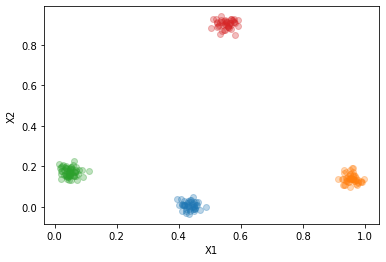

In [10]:
plotdataset(Xtr, ytr)

In [11]:
def train_test_evaluation(activation, regularization, learning_rate, max_iter, n_hidden):
  model = MLP(training_algorithm=Backpropagation(activation=activation, regularization=regularization, learning_rate=learning_rate, max_iter=max_iter, n_hidden=n_hidden))
  model.fit(Xtr,ytr)
  ypred = model.predict(Xtr,ytr)
  print("Train acc=", sum(ytr == ypred)/len(ytr))
  
  ypred = model.predict(Xte,yte)
  print("Test acc=",sum(yte== ypred)/len(yte))

  plotdataset(Xtr,ytr)
  plotPredictions(model,Xte)

Train acc= 1.0
Test acc= 0.99


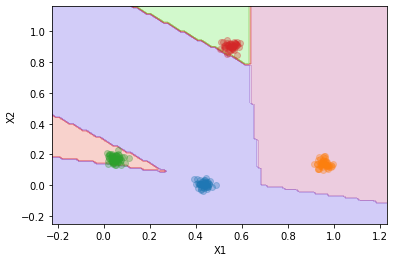

In [12]:
train_test_evaluation(activation=Tanh(), regularization=0.8, learning_rate=0.0001, max_iter=10000, n_hidden=[5])

Train acc= 1.0
Test acc= 0.9966666666666667


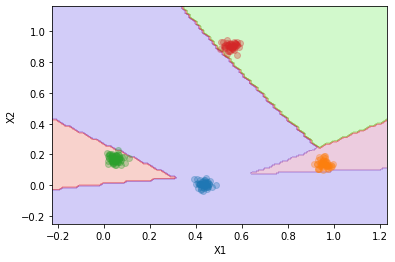

In [13]:
train_test_evaluation(activation=Sigmoid(), regularization=0.9, learning_rate=0.0001, max_iter=10000, n_hidden=[5])

Train acc= 1.0
Test acc= 0.9933333333333333


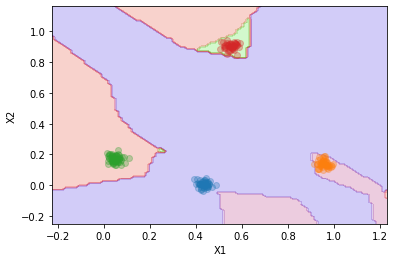

In [14]:
train_test_evaluation(activation=Relu(), regularization=1., learning_rate=0.0001, max_iter=10000, n_hidden=[16,8])